# Quantum Shortest Path Algorithm using Grover's Search (Heuristic)

This notebook implements a *heuristic* quantum shortest path algorithm using Grover's search. This approach is not guaranteed to find the absolute shortest path in all cases, especially for complex graphs, but it demonstrates how Grover's search can be applied to this problem. The algorithm finds *a* short path, and with sufficient iterations, the probability of finding the shortest path increases.

**Key Concepts:**

*   **Graph Representation:** The graph is represented as a dictionary where keys are nodes and values are lists of their neighbors.
*   **Path Enumeration:**  We use `networkx` to generate all simple paths between the start and end nodes up to a certain length. This is an *exponential* operation and is the main limitation of this implementation for larger graphs.
*   **Oracle:**  A simplified oracle is used that marks states corresponding to paths shorter than or equal to a given length.
*   **Diffusion Operator:** The standard Grover diffusion operator is used to amplify the amplitudes of the marked states.
*   **Grover's Iteration:** The oracle and diffusion operator are applied repeatedly.
*   **Path Length Iteration:** The algorithm iterates through possible path lengths, effectively performing a breadth-first search.

**Limitations:**

*   **Exponential Path Enumeration:**  The use of `networkx.all_simple_paths` makes this implementation unsuitable for large or densely connected graphs.
*   **Heuristic Nature:**  Due to the simplified oracle, the algorithm does not guarantee finding the absolute shortest path.
*   **Oracle Complexity:**  The oracle's complexity scales with the number of possible paths.


## Step 1: Import Necessary Libraries

In [9]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt

The imported libraries are:

*   **qiskit:** The main library for quantum computing.
    *   `QuantumCircuit`: For building quantum circuits.
    *   `QuantumRegister`, `ClassicalRegister`: For managing qubits and classical bits.
    *   `transpile`: For optimizing circuits for specific backends.
*   **qiskit.providers.aer.AerSimulator:** For simulating quantum circuits.
*   **qiskit.visualization.plot_histogram:** For visualizing measurement results.
*   **numpy:** For numerical operations (arrays, mathematical functions).
*   **math:** For mathematical functions (e.g., `ceil`, `log2`).
*   **networkx:** For graph manipulation and visualization.
*   **matplotlib.pyplot:** For plotting graphs and histograms.

## Step 2: Define the `grover_shortest_path` Function

In [10]:
def grover_shortest_path(graph, start_node, end_node, max_iterations=None):
    nodes = list(graph.keys())
    num_nodes = len(nodes)
    num_qubits = math.ceil(np.log2(num_nodes))
    all_paths = []
    for i in range(1, num_nodes + 1):
        for path in nx.all_simple_paths(nx.Graph(graph), source=start_node, target=end_node, cutoff=i):
            all_paths.append(path)
    if not all_paths:
        return [], 0, {}
    num_paths = len(all_paths)
    path_qubits = math.ceil(np.log2(num_paths))
    def node_to_binary(node):
        index = nodes.index(node)
        return format(index, f'0{num_qubits}b')
    def path_to_binary(path_index):
        return format(path_index, f'0{path_qubits}b')
    def oracle(shortest_length):
        oracle_qc = QuantumCircuit(path_qubits + 1, name="Oracle")
        for i, path in enumerate(all_paths):
            if len(path) <= shortest_length:
                path_binary = path_to_binary(i)
                for j, bit in enumerate(path_binary):
                    if bit == '0':
                        oracle_qc.x(j)
                oracle_qc.h(path_qubits)
                if hasattr(oracle_qc, 'mct'):
                    oracle_qc.mct(list(range(path_qubits)), path_qubits)
                else:
                    oracle_qc.mcx(list(range(path_qubits)), path_qubits)
                oracle_qc.h(path_qubits)
                for j, bit in enumerate(path_binary):
                    if bit == '0':
                        oracle_qc.x(j)
        return oracle_qc
    def diffusion_operator():
        diffusion_qc = QuantumCircuit(path_qubits + 1, name="Diffusion")
        for i in range(path_qubits):
            diffusion_qc.h(i)
        for i in range(path_qubits):
            diffusion_qc.x(i)
        diffusion_qc.h(path_qubits - 1)
        if hasattr(diffusion_qc, 'mct'):
            diffusion_qc.mct(list(range(path_qubits - 1)), path_qubits - 1)
        else:
            diffusion_qc.mcx(list(range(path_qubits - 1)), path_qubits - 1)
        diffusion_qc.h(path_qubits - 1)
        for i in range(path_qubits):
            diffusion_qc.x(i)
        for i in range(path_qubits):
            diffusion_qc.h(i)
        return diffusion_qc
    best_path = None
    best_length = float('inf')
    best_counts = {}
    iterations_used = 0
    if max_iterations is None:
        max_iterations = int(np.ceil(np.pi / 4 * np.sqrt(num_paths)))
    for k in range(1, num_nodes + 1):
        qc = QuantumCircuit(path_qubits + 1, path_qubits)
        for i in range(path_qubits):
            qc.h(i)
        for _ in range(max_iterations):
            qc.append(oracle(k), list(range(path_qubits + 1)))
            qc.append(diffusion_operator(), list(range(path_qubits + 1)))
        qc.measure(range(path_qubits), range(path_qubits))
        simulator = AerSimulator()
        compiled_circuit = transpile(qc, simulator)
        job = simulator.run(compiled_circuit, shots=1024)
        result = job.result()
        counts = result.get_counts(qc)
        most_frequent_path_index = int(max(counts, key=counts.get), 2)
        if 0 <= most_frequent_path_index < len(all_paths):
          current_path = all_paths[most_frequent_path_index]
          current_length = len(current_path)
          if current_length < best_length:
              best_length = current_length
              best_path = current_path
              best_counts = counts
              iterations_used = max_iterations
    return best_path, iterations_used, best_counts

The `grover_shortest_path` function implements the main algorithm:

*   **Input:**
    *   `graph`: A dictionary representing the graph.
    *   `start_node`: The starting node (string).
    *   `end_node`: The ending node (string).
    *   `max_iterations`: (Optional) Maximum number of Grover iterations.  Defaults to a heuristic value.
*   **Initialization:**
    *   `nodes`:  List of all nodes in the graph.
    *   `num_nodes`: Number of nodes.
    *   `num_qubits`: Number of qubits needed to represent nodes (logarithmic).
    *   `all_paths`:  List to store all simple paths between `start_node` and `end_node`.
    *   Iterates through possible path lengths (from 1 to `num_nodes`) and uses `nx.all_simple_paths` to find all paths of that length. *This is an exponential operation.*
    *   `num_paths`: The total number of paths found.
    *   `path_qubits`: Number of qubits to represent the paths.
    *   `node_to_binary`, `path_to_binary`: Helper functions to convert node names and path indices to binary strings.
*   **`oracle(shortest_length)` Function:**
    *   Creates a quantum circuit `oracle_qc`.
    *   Iterates through all found paths.
    *   If a path's length is less than or equal to `shortest_length`, it marks the corresponding state:
        *   Converts the path index to binary.
        *   Applies X gates to qubits corresponding to '0' bits in the binary representation.
        *   Applies a multi-controlled Toffoli (MCT/MCX) gate to apply a phase flip.
        *   Reverses the X gates.
*   **`diffusion_operator()` Function:**
    *   Creates a quantum circuit `diffusion_qc`.
    *   Implements the standard Grover diffusion operator (Hadamards, X gates, and a multi-controlled Z gate implemented as H-MCT/MCX-H).
*   **Main Grover Loop:**
    *   Initializes `best_path`, `best_length`, `best_counts`, and `iterations_used`.
    *   Calculates `max_iterations` heuristically if not provided.
    *   Iterates through possible path lengths (`k`):
        *   Creates a new quantum circuit `qc` for each path length.
        *   Initializes qubits in superposition (Hadamard gates).
        *   Performs Grover iterations (applies the oracle and diffusion operator `max_iterations` times).
        *   Measures the path qubits.
        *   Simulates the circuit using `AerSimulator`.
        *   Gets measurement counts.
        *   Finds the most frequent path index.
        *   Checks if the index is valid.
        *   If a shorter path is found, updates `best_path`, `best_length`, `best_counts`, and `iterations_used`.
*   **Return Value:**
    *   Returns `best_path` (list of nodes), `iterations_used` (int), and `best_counts` (dictionary).


## Step 3: Define the `draw_graph` Function

In [11]:
def draw_graph(graph, shortest_path=None):
    G = nx.Graph(graph)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    if shortest_path:
        edges = [(shortest_path[i], shortest_path[i+1]) for i in range(len(shortest_path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red', width=2)
    plt.show()

The `draw_graph` function visualizes the graph:

*   **Input:**
    *   `graph`: The graph (dictionary).
    *   `shortest_path`: (Optional) The shortest path found (list of nodes).
*   **Process:**
    *   Creates a `networkx` graph object `G` from the input dictionary.
    *   Calculates node positions using `nx.spring_layout` (you can use other layouts).
    *   Draws the graph using `nx.draw` with labels, node colors, and edge colors.
    *   If `shortest_path` is provided, it highlights the path in red using `nx.draw_networkx_edges`.
    *   Displays the graph using `plt.show()`.

## Step 4: Example Usage

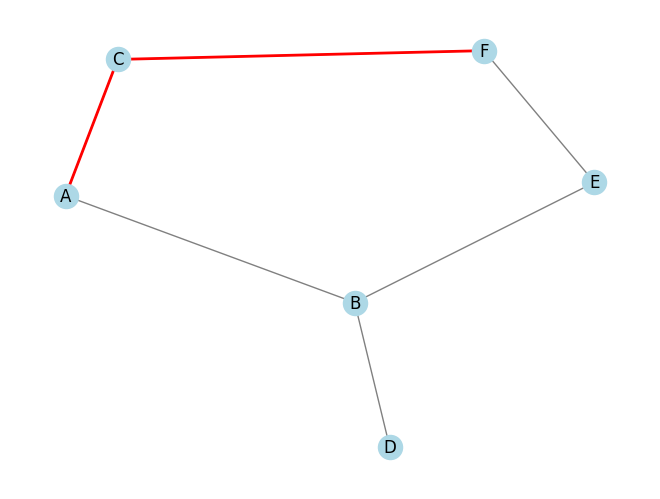

Shortest Path Found: ['A', 'C', 'F']
Iterations Used: 3
Measurement Counts: {'0100': 89, '0001': 63, '1100': 58, '0000': 73, '0010': 64, '1001': 69, '0101': 48, '1110': 56, '0111': 68, '0011': 66, '1011': 70, '1000': 46, '0110': 61, '1101': 61, '1010': 69, '1111': 63}


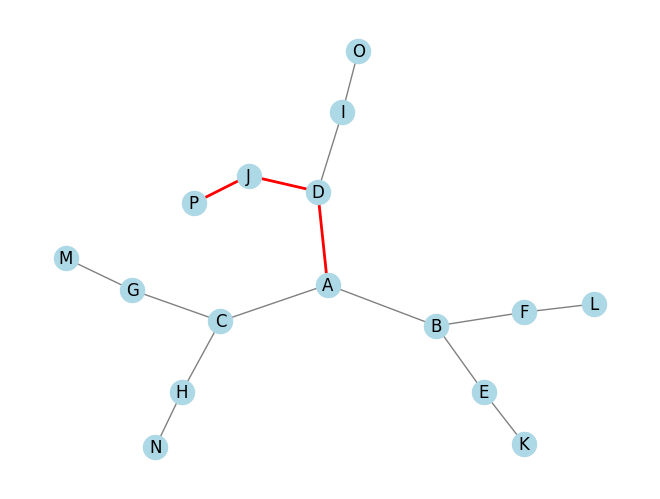

Shortest Path Found (Graph 2): ['A', 'D', 'J', 'P']
Iterations Used (Graph 2): 3
Measurement Counts (Graph 2): {'0100': 71, '1111': 58, '0001': 57, '1101': 53, '0010': 61, '0000': 64, '0110': 74, '1000': 77, '1100': 66, '1011': 71, '0011': 63, '0111': 58, '1001': 61, '0101': 58, '1110': 68, '1010': 64}


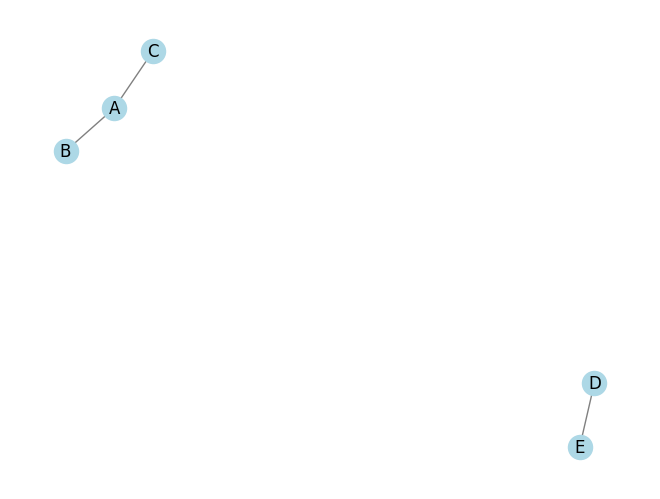

Shortest Path Found (Graph 3): []
Iterations Used (Graph 3): 0
Measurement Counts (Graph 3): {}


In [12]:
if __name__ == '__main__':
    graph = {
        'A': ['B', 'C'],
        'B': ['A', 'D', 'E'],
        'C': ['A', 'F'],
        'D': ['B'],
        'E': ['B', 'F'],
        'F': ['C', 'E']
    }
    start_node = 'A'
    end_node = 'F'
    shortest_path, iterations, counts = grover_shortest_path(graph, start_node, end_node)
    draw_graph(graph, shortest_path)
    print(f"Shortest Path Found: {shortest_path}")
    print(f"Iterations Used: {iterations}")
    print(f"Measurement Counts: {counts}")
    plot_histogram(counts)
    plt.show()
    graph2 = {
      'A': ['B', 'C', 'D'],
      'B': ['A', 'E', 'F'],
      'C': ['A', 'G', 'H'],
      'D': ['A', 'I', 'J'],
      'E': ['B', 'K'],
      'F': ['B', 'L'],
      'G': ['C', 'M'],
      'H': ['C', 'N'],
      'I': ['D', 'O'],
      'J': ['D', 'P'],
      'K': ['E'],
      'L': ['F'],
      'M': ['G'],
      'N': ['H'],
      'O': ['I'],
      'P': ['J']
    }
    start_node2 = 'A'
    end_node2 = 'P'
    shortest_path2, iterations2, counts2 = grover_shortest_path(graph2, start_node2, end_node2)
    draw_graph(graph2, shortest_path2)
    print(f"Shortest Path Found (Graph 2): {shortest_path2}")
    print(f"Iterations Used (Graph 2): {iterations2}")
    print(f"Measurement Counts (Graph 2): {counts2}")
    plot_histogram(counts2)
    plt.show()
    graph3 = {
      'A': ['B', 'C'],
      'B': ['A'],
      'C': ['A'],
      'D': ['E'],
      'E': ['D']
    }
    start_node3 = 'A'
    end_node3 = 'E'
    shortest_path3, iterations3, counts3 = grover_shortest_path(graph3, start_node3, end_node3)
    draw_graph(graph3)
    print(f"Shortest Path Found (Graph 3): {shortest_path3}")
    print(f"Iterations Used (Graph 3): {iterations3}")
    print(f"Measurement Counts (Graph 3): {counts3}")

The example usage section demonstrates the algorithm with three different graphs:

*   **Graph 1 (Simple Graph):**
    *   Defines a simple graph `graph`.
    *   Sets `start_node` to 'A' and `end_node` to 'F'.
    *   Calls `grover_shortest_path` to find a short path.
    *   Calls `draw_graph` to visualize the graph and highlight the found path.
    *   Prints the results (path, iterations, counts).
    *   Displays the histogram of measurement counts.
*   **Graph 2 (Larger Graph):**
    *   Defines a larger, more connected graph `graph2`.
    *   Sets `start_node2` to 'A' and `end_node2` to 'P'.
    *   Runs the algorithm and displays the results similarly to Graph 1.
*   **Graph 3 (Disconnected Graph):**
    *   Defines a graph `graph3` where no path exists between 'A' and 'E'.
    *   Sets `start_node3` to 'A' and `end_node3` to 'E'.
    *   Runs the algorithm.  The expected result is an empty path, 0 iterations, and an empty counts dictionary.
*   **`if __name__ == '__main__':`:** Ensures that the example code runs only when the script is executed directly (not when imported as a module).